# __Sao Paulo Rent Price Prediction__

## __Introduction__

The real estate market is one of the most vital and dynamic sectors of the economy, especially in large cities like São Paulo. In this project, data science techniques will be applied to create algorithms to predict rental prices for houses and apartments in the city. Accurate prediction of rental prices is crucial for both tenants and landlords, aiding informed decision making and streamlining the rental process.

__Possible benefits of this type of algorithm:__

For Tenants: Helps search for properties with the best cost-benefit considering their needs and budget. For Landlords and Investors: Provides insights into the market value of properties, helping set competitive and fair prices. For the Real Estate Market: Contributes to market transparency and efficiency, providing a clearer view of price trends.

__Challenges:__

Price Variability: São Paulo is a city with great diversity of neighborhoods and property types, generating a wide variation in rental prices. 
Heterogeneous Data: Integrating and analyzing different data sources like location, property size, local infrastructure and property features. 
Market Changes: The real estate market is subject to rapid changes due to economic, political and social factors.

__Approach:__

LightGBM was used, a gradient boosting machine learning algorithm known for its efficiency, accuracy and ability to handle large data volumes.

## __Information about the data used in this project__
The main dataset used in this project was obtained from the public datasets section on Kaggle at the link https://www.kaggle.com/datasets/renatosn/sao-paulo-housing-prices;

The dataset that contains correctly entered data from the neighborhoods of São Paulo was formulated from the dataset contained in kaggle at the link https://www.kaggle.com/datasets/markfinn1/bairros-de-so-paulo and page information https://www.saopaulobairros.com.br/.

### __First data view__

In [1]:
# Standard library imports
import re
import unicodedata

# Third-party imports
from fuzzywuzzy import fuzz, process
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Deactivating the future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Load data from CSV file into a Pandas DataFrame
df = pd.read_csv('data.csv')

# Print shape of DataFrame to see number of rows and columns
print(df.shape)

# Display first 5 rows of the DataFrame
df.head()

(11657, 8)


,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654


In [3]:
# Reordering the columns to make it easier to evaluate the dataset
df = df.loc[:, ['address', 'district', 'type', 'total', 'rent', 'area', 'bedrooms', 'garage']]

In [4]:
# Print information about the DataFrame including data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   type      11657 non-null  object
 3   total     11657 non-null  int64 
 4   rent      11657 non-null  int64 
 5   area      11657 non-null  int64 
 6   bedrooms  11657 non-null  int64 
 7   garage    11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


In [5]:
# Generate descriptive statistics for numerical columns in the DataFrame
df.describe()

,total,rent,area,bedrooms,garage
count,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000
mean,4080.030625,3250.814789,84.655658,1.966286,1.060393
std,3352.480274,2650.711557,74.020536,0.931313,1.132349
min,509.000000,500.000000,0.000000,0.000000,0.000000
25%,1996.000000,1590.000000,40.000000,1.000000,0.000000
50%,3057.000000,2415.000000,60.000000,2.000000,1.000000
75%,4774.000000,3800.000000,96.000000,3.000000,2.000000
max,28700.000000,25000.000000,580.000000,6.000000,6.000000


At first glance, it can be seen that the dataset does not have any missing data and there do not appear to be any significant outliers for the numerical features.

### __Initial Exploratory Data Analysis__

The idea here is to verify if there is correlation between the numerical variables and the target variable ('rent'), analyze their distributions, check for any data type issues, and based on that, if necessary, create some strategy for cleaning, preprocessing and feature engineering.

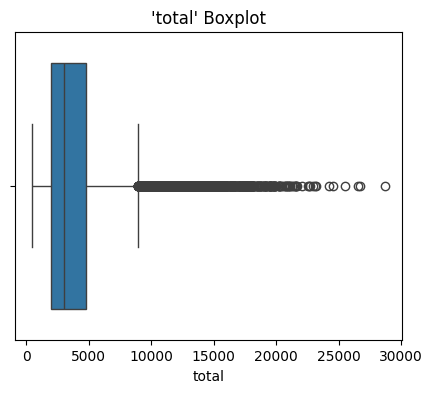

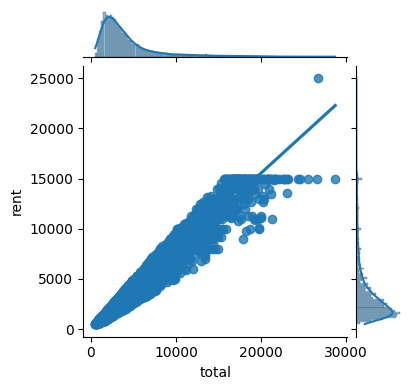

In [6]:
# For the 'total' feature:
# Create a figure with specified size
plt.figure(figsize=(5, 4))  

# Add title to the plot
plt.title("'total' Boxplot")

# Generate boxplot for 'total' column
sns.boxplot(x=df['total'])

# Create jointplot showing scatterplot
# and linear regression between 'total' and 'rent'
sns.jointplot(x=df['total'], y=df['rent'], kind='reg', height=4)

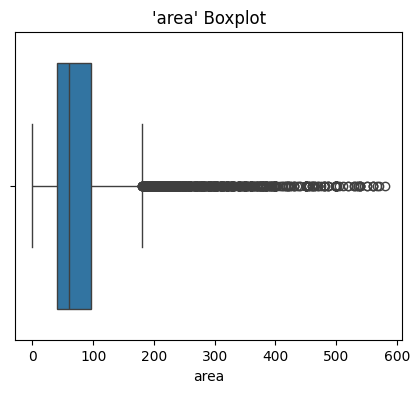

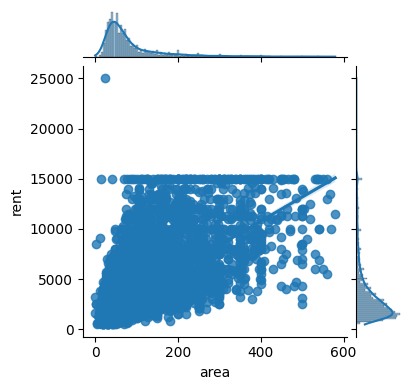

In [7]:
# For the 'area' feature:
# Create a figure with specified size
plt.figure(figsize=(5, 4))  

# Add title to the plot
plt.title("'area' Boxplot")

# Generate boxplot for 'area' column
sns.boxplot(x=df['area'])

# Create jointplot showing scatterplot
# and linear regression between 'area' and 'rent'
sns.jointplot(x=df['area'], y=df['rent'], kind='reg', height=4)

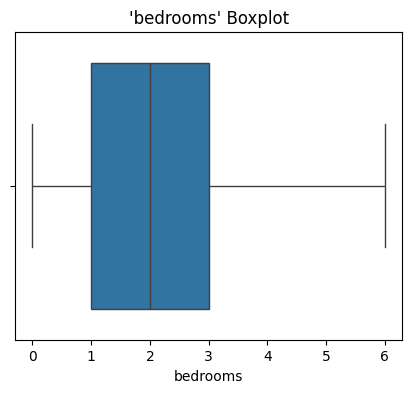

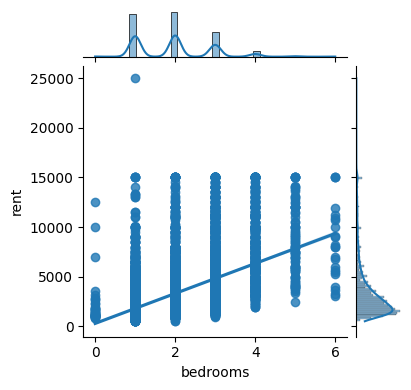

In [8]:
# For the 'bedrooms' feature:
# Create a figure with specified size
plt.figure(figsize=(5, 4))  

# Add title to the plot
plt.title("'bedrooms' Boxplot")

# Generate boxplot for 'bedrooms' column
sns.boxplot(x=df['bedrooms'])

# Create jointplot showing scatterplot
# and linear regression between 'bedrooms' and 'rent'
sns.jointplot(x=df['bedrooms'], y=df['rent'], kind='reg', height=4)

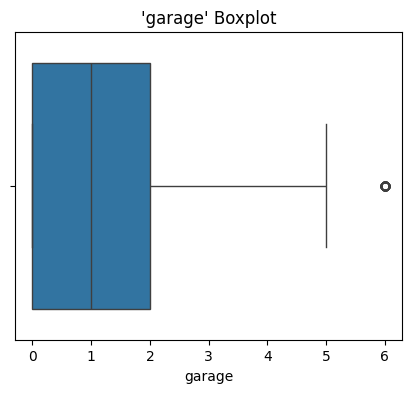

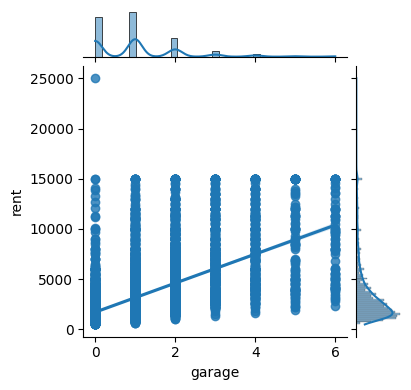

In [9]:
# For the 'garage' feature:
# Create a figure with specified size
plt.figure(figsize=(5, 4))  

# Add title to the plot
plt.title("'garage' Boxplot")

# Generate boxplot for 'garage' column
sns.boxplot(x=df['garage'])

# Create jointplot showing scatterplot
# and linear regression between 'garage' and 'rent'
sns.jointplot(x=df['garage'], y=df['rent'], kind='reg', height=4)

In [10]:
# Just checking if there are any data type errors in the columns below
print(df['address'].apply(type).value_counts())
print('\n')
print(df['district'].apply(type).value_counts())
print('\n')
print(df['type'].apply(type).value_counts())

address
<class 'str'>    11657
Name: count, dtype: int64


district
<class 'str'>    11657
Name: count, dtype: int64


type
<class 'str'>    11657
Name: count, dtype: int64


One first point verified is that there is a significant amount of apparent outliers when looking at the boxplots of continuous variables. In this case caution must be taken, because in the real estate segment there are several 'hidden' factors that can significantly affect property prices, consequently making the data not actually considered as outliers. Furthermore, there do not appear to be significant apparent problems in the data and most importantly, there is correlation, at least apparent, between the available variables and the target variable. This means that there will likely be success in modeling.

### __Data cleaning and preprocessing__

One of the precautions we must take beforehand is with the categorical variables, especially the variables with district and street names. Most likely such features have equal district names written in different ways either with accents and their absence, extra empty spaces, abbreviations, unnoticed typing errors among others. In this case, the first step is to clean these possible errors using functions that make all letters lowercase, remove extra spaces and accents. With this, for the district names, we will compare these data with a list that will serve as a 'key' that contains the names of all the neighborhoods and districts of the city of São Paulo written correctly, thereby standardizing the names of all districts. For street addresses the problem is a bit more complex, given the extensive amount of names and possibilities. In this case, only the initial cleaning mentioned will be done.

In [11]:
# Function to clean and normalize text:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove accents and special characters
    text = ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if unicodedata.category(c) != 'Mn' and c.isascii()
    )

    # Remove extra whitespace
    text = text.strip()

    return text

# Apply clean_text function to DataFrame columns to clean and normalize the text
df['address'] = df['address'].apply(clean_text)
df['district'] = df['district'].apply(clean_text)

In [12]:
# Load neighborhoods data for São Paulo from CSV file into a DataFrame which contains the names of all neighborhoods and districts of São Paulo spelled correctly
sp_neighborhoods = pd.read_csv('sp_neighborhoods.csv')

In [13]:
# Function to correct district names based on a 'sp_neighborhoods' 
def correct_district(name, choices, limit=1):
    return process.extractOne(name, choices)[0]

# Ensure sp_neighborhoods column is a list
neighborhood_list = sp_neighborhoods['sp_neighborhoods'].tolist()

# Apply function to correct district names in the DataFrame  
df['district_ok'] = df['district'].apply(correct_district, args=(neighborhood_list,))

In [14]:
# Reorder DataFrame with new column order
columns_change = df.columns.tolist()
columns_change.insert(columns_change.index('district') + 1, columns_change.pop(columns_change.index('district_ok')))
df = df[columns_change]

# Checking if the new column 'district_ok' was generated correctly
df.head(10)

,address,district,district_ok,type,total,rent,area,bedrooms,garage
0,rua herval,belenzinho,belenzinho,Studio e kitnet,2939,2400,21,1,0
1,avenida sao miguel,vila marieta,vila marieta,Studio e kitnet,1345,1030,15,1,1
2,rua oscar freire,pinheiros,pinheiros,Apartamento,4661,4000,18,1,0
3,rua julio sayago,vila re,vila re,Casa em condomínio,1954,1750,56,2,2
4,rua barata ribeiro,bela vista,bela vista,Studio e kitnet,4654,4000,19,1,0
5,rua domingos paiva,bras,bras,Apartamento,4587,3800,50,2,1
6,rua guararapes,brooklin paulista,brooklin paulista,Apartamento,5187,3500,72,2,1
7,avenida casper libero,centro,centro,Studio e kitnet,2244,1727,26,1,0
8,rua jose peres campelo,piqueri,piqueri,Apartamento,1592,1200,32,2,0
9,rua guaperuvu,vila aricanduva,vila aricanduva,Apartamento,1501,1200,36,1,0


In [15]:
# Checking how many neighborhoods were probably registered wrongly
print(df['district'].nunique())
print(df['district_ok'].nunique())
df.drop('district', axis=1, inplace=True)

1086
871


In [16]:
# Checking if the 'type' column possibly has any errors in its categories
df['type'].value_counts()

type
Apartamento           7194
Casa                  2841
Studio e kitnet       1381
Casa em condomínio     241
Name: count, dtype: int64

As it was possible to verify, apparently there were 215 district names written incorrectly, therefore this cleaning was useful and successfully performed. As for the data from the 'type' feature there is no apparent error, so nothing needs to be done about it.

### __Feature engineering__

Regarding feature engineering, the first thing we will do is create new features, since we have few features provided by the original dataset. In this sense, some features will be created that can capture relationships not explicitly shown, such as nonlinear, quadratic, cubic, logarithmic relationships among others. Obviously not all created features will have practical utility in model performance, but this will be investigated in more detail after modeling through the feature importance process, which can only be performed after modeling itself.

__There is an extremely important factor that must be observed:__
The 'total' feature is composed of the rental price (the 'rent' feature) and other expenses related to the property rental. Now, the variable we want to predict is precisely the 'rent' feature, therefore, a feature that in its composition contains the target variable is an intense source of data leakage since it implicitly contains the answer we want to discover. Therefore, using this feature would be a serious mistake and therefore it must be discarded. In the modeling we will initially use this feature for the purpose of showing how data leakage can generate false results leading a model to produce misleading results.

One way to try to mitigate this problem is to create the 'expenses' variable which will be the subtraction of the 'rent' variable from the 'total' variable, that is, a feature that actually contains the additional costs to the rent. However, in practice, we do not know if this data would be available or not and since this data was not presented in this way by the original dataset this would also be a possible source of data leakage. We will also create a model that uses this variable to see how much it influences the result, however, the most correct and safe way is not to use neither the 'total' variable nor the 'expenses' variable.

In [17]:
# Total monthly expenses
df['expenses'] = df['total'] - df['rent']

# Squared bedrooms
df['bedrooms_squared'] = df['bedrooms'] ** 2 

# Squared area
df['area_squared'] = df['area'] ** 2

# Interaction between area and bedrooms
df['area_bedrooms_interaction'] = df['area'] * df['bedrooms']  

# Interaction between area and garage
df['area_garage_interaction'] = df['area'] * df['garage']

# Length of address text 
df['address_length'] = df['address'].str.len()

# Number of words in address
df['address_word_count'] = df['address'].str.split().str.len() 

# Binary garage indicator 
df['garage_indicator'] = (df['garage'] > 0).astype(int)

# Log transformed area
df['log_area'] = np.log(df['area'] + 1)

# Square root of area
df['sqrt_area'] = np.sqrt(df['area'])

# Cubic root of area
df['cbrt_area'] = np.cbrt(df['area'])

# Bedrooms per area 
df['bedrooms_per_area'] = df['bedrooms'] / (df['area'] + 0.0001)

# Garage spots per area
df['garage_per_area'] = df['garage'] / (df['area'] + 0.0001) 

# Sum of bedrooms and garage spots  
df['bedrooms_plus_garage'] = df['bedrooms'] + df['garage']

# Product of bedrooms and garage spots
df['bedrooms_times_garage'] = df['bedrooms'] * df['garage']

# Area per bedroom 
df['area_per_bedroom'] = df['area'] / (df['bedrooms'] + 0.0001)

# Area per garage spot
df['area_per_garage'] = df['area'] / (df['garage'] + 0.0001)

# Ratio of bedrooms to garage spots
df['bedrooms_to_garage_ratio'] = df['bedrooms'] / (df['garage'] + 0.0001)

# Get object/categorical columns to convert into 'category' dtype
categorical_features = df.select_dtypes(include='object').columns  
df[categorical_features] = df[categorical_features].astype('category')

<Axes: >

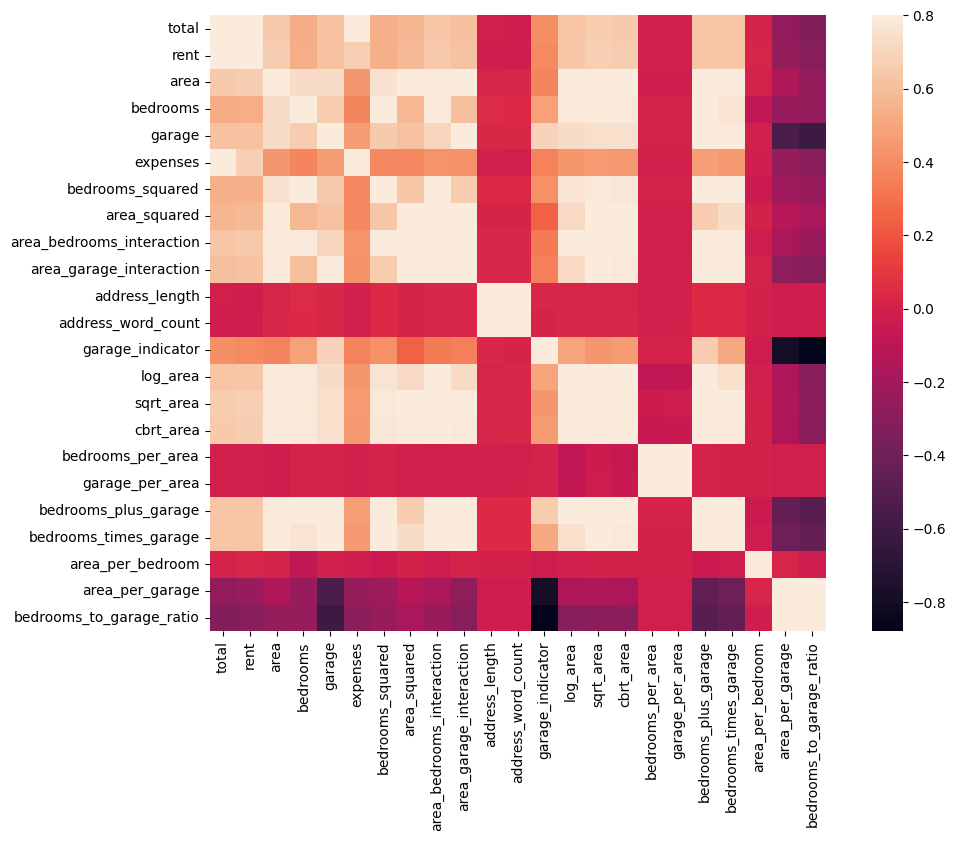

In [18]:
# Get numerical columns 
num_cols = df.select_dtypes(include=['float64', 'int64']).columns  

# Calculate correlation between numerical columns
corr = df[num_cols].corr()  

# Create figure and axes
f, ax = plt.subplots(figsize=(12, 8))

# Plot heatmap of correlation matrix 
sns.heatmap(corr, vmax=0.8, square=True)

As mentioned previously, it can be observed from the correlation heat map that the 'total' feature has the highest correlation with the 'rent' variable, which was already expected.

### __Model training and performance evaluation__

Finally, reaching the actual model building stage: We will use LightGBM as a base, which is a powerful Gradient Boosting Machine model that has several strengths we can leverage for our problem. This model is invariant to data distribution or normality, that is, it is not necessary to perform any standardization or normalization procedures on the data. The model can automatically work with categorical variables without the need for encoding, which facilitates modeling and prevents problems such as uncontrolled increase in dimensionality. In addition, it is a model that works quickly with large amounts of data.

In [19]:
# Function to train a LightGBM regression model and evaluate performance
def regression_model(df, colunas_a_excluir):

    # Separate features, target and  splitting data into train and test
    X = df.drop(colunas_a_excluir, axis=1)
    y = df['rent']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train LGBMRegressor model with GridSearch for hiperparameter tuning and cross-validation
    lgbm = LGBMRegressor(random_state=42)
    param_grid = {
        'verbosity': [-1],
        'num_leaves': [31, 50, 70, 100],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train, categorical_feature=X.select_dtypes(include='object').columns)

    # Make predictions on test set, evaluate model performanceband feature importances
    y_pred = grid_search.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    best_model = grid_search.best_estimator_
    importances = best_model.feature_importances_
    feature_importances = pd.DataFrame(importances, index=X_train.columns, columns=["Importance"]).sort_values("Importance", ascending=False)
    
    return grid_search.best_params_, rmse, mae, r2, feature_importances, y_test, y_pred

In [20]:
# Testing the model with different sets of deleted columns
model_results = []
columns_to_test = [['rent'], ['rent', 'total'], ['rent', 'total', 'expenses']]

for columns in columns_to_test:
    best_params, rmse, mae, r2, feature_importances, y_test, y_pred = regression_model(df, columns)
    model_results.append((columns, best_params, rmse, mae, r2, feature_importances, y_test, y_pred))

# Printing the results
for results in model_results:
    print(f"Deleted columns: {results[0]}")
    print(f"Best parameters: {results[1]}")
    print(f"RMSE: {results[2]}, MAE: {results[3]}, R²: {results[4]}\n")

Deleted columns: ['rent']
Best parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'verbosity': -1}
RMSE: 86.01730438190404, MAE: 33.546137178026186, R²: 0.9989527740020313

Deleted columns: ['rent', 'total']
Best parameters: {'learning_rate': 0.05, 'num_leaves': 31, 'verbosity': -1}
RMSE: 1480.7780354618787, MAE: 928.6315131106284, R²: 0.689652189314992

Deleted columns: ['rent', 'total', 'expenses']
Best parameters: {'learning_rate': 0.1, 'num_leaves': 50, 'verbosity': -1}
RMSE: 1573.1022720299804, MAE: 978.232846534936, R²: 0.6497463458202686



As expected and already anticipated, the model has very high accuracy when using the 'total' variable, but it is clear that this is just a very strong data leakage. Using the 'expenses' variable and not using the 'total' variable greatly lowers model performance, but as mentioned earlier, depending on the perspective, it can still be considered a type of data leakage. That is, the most sensible thing to do is to consider the third model, which excludes the 'total' and 'expenses' features.

As for the chosen model (third model), despite having much lower performance than the first, looking specifically at it, it has reasonable performance, making it useful, since it clearly manages to capture a relationship between the variables used in the modeling and the target variable.

In [21]:
# Checking which features are relevant when we do not use the 'total' and 'expense' features in the model
model_results[2][5]

,Importance
district_ok,1125
address,731
area,417
address_length,415
area_garage_interaction,408
area_bedrooms_interaction,369
bedrooms_per_area,326
garage_per_area,314
type,193
area_per_bedroom,183


As observed above, there are 6 variables that are completely unnecessary for the model and can be excluded, which will likely result in a model with exactly the same previous performance.

In [22]:
# Testing the model droping the features that apparently not provide any improvement (feature importance evaluation)to see what happens.
new_model_results = []
columns_to_drop = ['rent', 'total', 'expenses', 'bedrooms_squared', 'cbrt_area', 'sqrt_area', 'log_area', 'garage_indicator', 'area_squared']
best_params, rmse, mae, r2, feature_importances, y_test, y_pred = regression_model(df, columns_to_drop)
new_model_results.append((columns, best_params, rmse, mae, r2, feature_importances, y_test, y_pred))

# Printing the results
print(f"Deleted columns: {new_model_results[0][0]}")
print(f"Best parameters: {new_model_results[0][1]}")
print(f"RMSE: {new_model_results[0][2]}, MAE: {new_model_results[0][3]}, R²: {new_model_results[0][4]}\n")
print('\n')

Deleted columns: ['rent', 'total', 'expenses']
Best Parameters: {'learning_rate': 0.1, 'num_leaves': 50, 'verbosity': -1}
RMSE: 1573.1022720299804, MAE: 978.232846534936, R²: 0.6497463458202686





Finally, it is necessary to evaluate whether there is heteroscedasticity in the created model and if so, whether there is a range with greater reliability in which the model can be used.

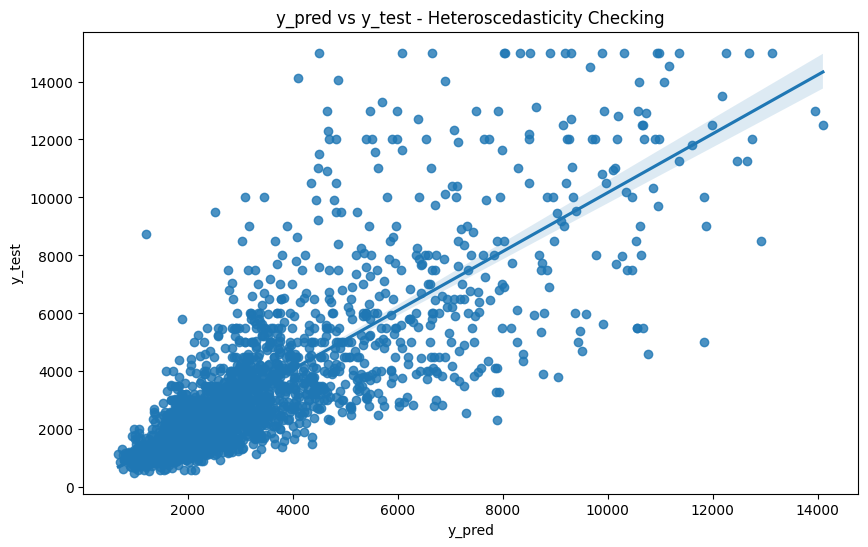

In [23]:
# Define figure size 
plt.figure(figsize=(10, 6))

# Create regression plot  
sns.regplot(x=new_model_results[0][7], y=new_model_results[0][6])

# Set axis labels
plt.xlabel('y_pred')  
plt.ylabel('y_test')

# Set plot title 
plt.title('y_pred vs y_test - Heteroscedasticity Checking')  

# Display plot
plt.show()

From the graph above it is possible to verify that there is indeed heteroscedasticity, mainly for the higher values, which shows that lower values such as up to 8000 are more reliable to be used by the model.

### __Conclusion__

Finally, the whole process highlights the challenges of modeling to predict rental prices for real estate properties. As already known beforehand, the data is a fundamental part of the data science modeling process. Bad data generates bad models. Good data generates good models. The data used in this small project was of median quality. In addition, there were not a significant number of features that captured different aspects related to real estate. So, in this sense, one way to improve the model made is to get more data from reliable sources that can bring better performance to the model.

The limitations of the current dataset with a small number of features led to a model with decent but not great performance. Access to richer data with more relevant explanatory variables related to location, property attributes, macroeconomic factors etc. can significantly enhance model accuracy and reliability.

Overall, the project demonstrates the promise of using machine learning to predict real estate prices, but also the need for quality, large-scale data and sound modeling practices to develop robust and useful models for real-world application.